MoM:

*   birth & death rate. allow fraction of population to live on after each time step
*   agents only interact in a surrounding
* put agents on a grid
* wolf cant mutate into polar bear
* random prob of death, fitness inversely proportional to death rate
* Allow setting of initial distribution of agents/strategies
* using relative fitness for reproduction probability of a single agent ( relative to the fittest in a species scaled between min and max)
* fitness of all agents set to 0 after each step
* make it one agent, multiple strategies
* add environmental perturbations like resource availability and temperature
* resource availability - give few options - medium, high, abundant, etc. each strategy survives with a particular resource availability. If its low = 0, medium = 1, high = 2; then if bear survivesin medium (1) resource availability, then only if the number becomes lesser than 1 (with some particular probability), then only fitness decrease, death rate increase, popoulation size decrease. if resource availability is >=1, it will always survive - fitness increases, death rate decreases, population size increases
* temperature - each strategy survives in a particular temperature range. there is a global temperature. global temperature is used on an agent to calculate the agents survival probability using e^-((x-a)/k)^2
* timer that kills agents after 3 steps
* fraction of occupied cells as probability of death ( competition )
* add movement to the agents




In [2]:
!pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 686.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  0%|          | 0/100 [00:00<?, ?it/s]

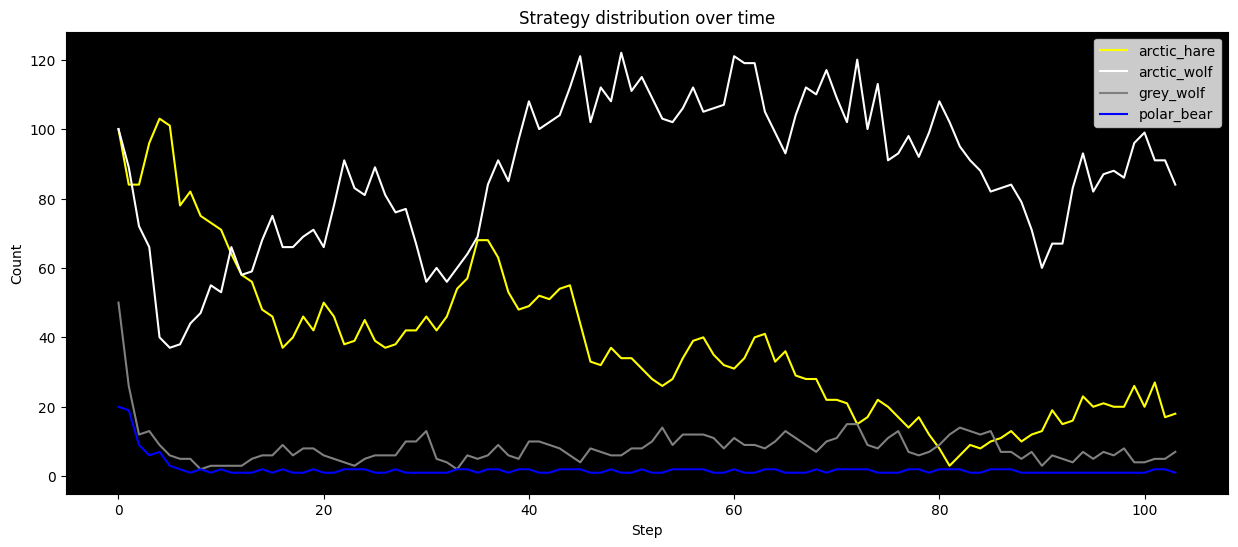

In [164]:
import random
from mesa import Model, Agent
from mesa.time import BaseScheduler
from mesa.space import SingleGrid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML
from tqdm.auto import tqdm

# Define the strategies and their corresponding traits
strategies = {
    'arctic_hare' : {'running_speed':'fast','ear_length':'short','temperature': [-10,10],'color': [1, 1, 0], 'time': 3,'speed': 4,'children':1}, # yellow
    'arctic_wolf': {'coat_color': 'white', 'fur_thickness': 'thick','temperature':[-16,10],'color': [1,1,1], 'time': 3, 'speed': 3,'children':1}, # white
    'grey_wolf': {'coat_color': 'grey', 'fur_thickness': 'thin','temperature':[-3,10],'color': [0.5,0.5,0.5], 'time': 3, 'speed': 3,'children':1}, # grey
    'polar_bear': {'ear_length': 'short', 'claw_length': 'long','temperature':[-25,10],'color': [0,0,1], 'time': 3, 'speed': 2,'children':1} # blue
}

# Define the payoff matrix as a 2D Matrix with row being the agent whose payoff
# is calculated from the matrix. The indices are ordered in the order of the
# strategies dictionary.
payoff_matrix = [
    [ 150.0, -100.0, -70.0,  -50.0 ],  # Payoffs for arctic_hare
    [ 200.0,   60.0,  20.0,  -80.0 ],  # Payoffs for arctic_wolf
    [  70.0,   30.0,  60.0, -100.0 ],  # Payoffs for grey_wolf
    [  50.0,   70.0, 100.0,   50.0 ]   # Payoffs for polar_bear
]

class Animal(Agent):
    def __init__(self, unique_id, model, strategy):
        super().__init__(unique_id, model)
        self.strategy = strategy
        self.fitness = 0
        self.timer = strategies[self.strategy]['time']
        self.move_distance = strategies[self.strategy]['speed']
        self.direction_list = [(i, j) for i in range(-self.move_distance, self.move_distance+1) for j in range(-self.move_distance, self.move_distance+1)]
        self.movement_direction = None

    def get_color(self):
        return strategies[self.strategy]['color']

    def interact(self):
        # Get the neighboring agents
        neighbors = self.model.grid.get_neighbors(self.pos, moore = True, include_center = False, radius = 10)

        # Map strategies to indices
        strategy_to_index = {strategy: index for index, strategy in enumerate(strategies)}

        # Get the payoff from the matrix
        for other_agent in neighbors:
            payoff = payoff_matrix[strategy_to_index[self.strategy]][strategy_to_index[other_agent.strategy]]
            self.fitness += payoff

    def survive_probability(self,global_temp,optimal_temp):

        # Calculate the survival probability using the normal distribution
        survival_prob = np.e**(-((global_temp-optimal_temp[0])/optimal_temp[1])**2)

        return survival_prob

    def reproduce(self, mutation_rate, child_pos):
      # Implement mutation logic here
      new_strategy = self.strategy
      if self.strategy in ['arctic_wolf', 'grey_wolf'] and random.random() < mutation_rate:
          new_strategy = random.choice(['arctic_wolf', 'grey_wolf'])

      # Create a new instance of the Animal class with the new strategy
      child = Animal(self.model.next_id, self.model, new_strategy)
      child.movement_direction = self.movement_direction

      self.model.grid.place_agent(child, child_pos)

      return child

    def reset_fitness(self):
      self.fitness = 0

    def is_within_bounds(self, pos):
      x, y = pos
      return 0 <= x < self.model.grid.width and 0 <= y < self.model.grid.height

    def move(self):
      if self.timer > 2 or self.movement_direction is None:

          random.shuffle(self.direction_list)
          for delta_pos in self.direction_list:

              new_pos = (self.pos[0] + delta_pos[0], self.pos[1] + delta_pos[1])
              if new_pos in self.model.grid.empties and self.is_within_bounds(new_pos):
                  self.model.grid.move_agent(self, new_pos)
                  self.movement_direction = delta_pos
                  break
      else:
          new_pos = (self.pos[0] + self.movement_direction[0], self.pos[1] + self.movement_direction[1])
          if new_pos in self.model.grid.empties and self.is_within_bounds(new_pos):
              self.model.grid.move_agent(self, new_pos)


class EvolutionModel(Model):
    def __init__(self, width, height, population_distribution, mutation_rate, temperature):
        super().__init__()
        self.mutation_rate = mutation_rate
        self.schedule = BaseScheduler(self)
        self.grid = SingleGrid(width, height, False)
        self.custom_agents = []
        self.strategy_counts_history = [population_distribution]  # Store strategy counts at each step
        self.create_agents()
        self.global_temp = temperature

    def create_agents(self):
        for strategy, count in self.strategy_counts_history[0].items():
            for _ in range(count):
                agent = Animal(self.next_id, self, strategy)
                self.schedule.add(agent)
                self.grid.move_to_empty(agent)
                self.custom_agents.append(agent)

    def step(self):

        pbar.update(1)
        # Calculate the total fitness of each strategy
        max_fitnesses = {strategy: 0 for strategy in strategies}
        min_fitnesses = {strategy: np.inf for strategy in strategies}

        # Simulate interactions and calculate fitness
        for agent in self.custom_agents:
            agent.move()
            agent.interact()
            max_fitnesses[agent.strategy] = max(max_fitnesses[agent.strategy], agent.fitness)
            min_fitnesses[agent.strategy] = min(min_fitnesses[agent.strategy], agent.fitness)

        # Determine the probability of reproducing for each agent
        for agent in self.custom_agents[:]:

            interval = max_fitnesses[agent.strategy] - min_fitnesses[agent.strategy]
            prob = 1
            if interval != 0:
              prob = (agent.fitness - min_fitnesses[agent.strategy]) / interval

            neighborhood = self.grid.get_neighborhood(agent.pos, moore=True, include_center=False, radius= 2)
            num_empty = 0
            cells = 0

            for pos in neighborhood:
                cells += 1
                if self.grid.is_cell_empty(pos) :
                    num_empty += 1

            frac = num_empty / cells

            # Generate a random number to see if the agent can reproduce
            if random.random() < prob:
              for i in range(strategies[agent.strategy]['children']):
                # Get the list of neighboring cells that are empty
                neighbors_reproduction = self.grid.iter_neighborhood(agent.pos, moore=True, include_center=False, radius=3)
                neighboring_empty_cells_reproduction = [pos for pos in neighbors_reproduction if self.grid.is_cell_empty(pos)]
                if not neighboring_empty_cells_reproduction:
                  break
                i += 1
                # If there are empty neighboring cells, place the child in one of them
                child_pos = random.choice(neighboring_empty_cells_reproduction)

                # The agent can reproduce, create a child
                child = agent.reproduce(self.mutation_rate,child_pos)
                self.custom_agents.append(child)

            # Decrement the time_left for the agent
            agent.timer -= 1

            environment_probability = agent.survive_probability(self.global_temp,strategies[agent.strategy]['temperature'])

            # Generate a ranodm number to see if the agent dies or If the agent's time_left reaches zero, remove the agent
            if random.random() > environment_probability or random.random() > prob or random.random() > frac  or agent.timer == 0 :
                self.custom_agents.remove(agent)
                self.grid.remove_agent(agent)


        # Store strategy counts at the end of each step
        strategy_counts = {strategy: 0 for strategy in strategies.keys()}
        for agent in self.custom_agents:
            strategy_counts[agent.strategy] += 1
            # reset all fitness to 0
            agent.reset_fitness()
        self.strategy_counts_history.append(strategy_counts)

    def visualize_grid(self):
        grid = np.zeros((self.grid.width, self.grid.height, 3))
        for agent in self.custom_agents:
            grid[agent.pos[0]][agent.pos[1]] = agent.get_color()
        return grid

# Visualization and analysis code can be added here
def plot_counts(model):
    plt.figure(figsize=(15, 6))
    ax = plt.gca()  # Get the current axes
    ax.set_facecolor('black')  # Set the axes background to black
    # Plot a line for each strategy
    for strategy in strategies.keys():
        counts = [step[strategy] for step in model.strategy_counts_history]
        plt.plot(counts, label=strategy,color = strategies[strategy]['color'])

    plt.xlabel('Step')
    plt.ylabel('Count')
    plt.title('Strategy distribution over time')
    plt.legend()
    plt.show()

strategy_population = {
    'arctic_hare' : 100,
    'arctic_wolf': 100,
    'grey_wolf': 50,
    'polar_bear': 20
}

model = EvolutionModel( 75,75,population_distribution=strategy_population, mutation_rate =0.1,temperature = -16)
num_steps = 100

def update(frame):
    model.step()  # Advance the model by one step
    im.set_array(model.visualize_grid())
    return [im]

fps = 2
interval = 1000 // fps  # frame_rate=1 will give interval=1000 ms

pbar = tqdm(total = num_steps)

ani = FuncAnimation(fig, update, frames=range(num_steps), blit=True, interval=interval)

# Convert the animation to HTML
html = HTML(ani.to_html5_video())

# Display the animation
display(html)

plot_counts(model)

